# MMCi Computational Assignment 1: Predicting Clinic No-Shows
---
In this exercise, we will work with a dataset of [over 100k clinic appointments](https://www.kaggle.com/joniarroba/noshowappointments) to predict no-shows based on patient characteristics and appointment scheduling details. After importing and preprocessing the data, we will train logistic regression and multilayer perceptron models and compare their performance. After selecting a final model, we will apply it to a test set that we initially set aside.

All of the code has already been executed, and does not need to be modified. Instead, follow the written material and results, then respond to the questions posed throughout the exercise in a separate document. It is not important to understand the details of the code blocks, but it is important to think conceptually about the steps that are taken to read the data, prepare it for modeling, and train a model.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier

### Data Import
We will begin by loading the data from .csv file with the 'pandas' data analysis library. Data is read with the `pd.read_csv()` command, which creates a pandas dataframe from the specified .csv file. In this command, we also tell pandas that some columns should be interpreted as a datetime, and others should be interpreted as categorical variables. After reading the file, we will drop unneeded columns using the `df.drop()` command, drop rows with missing values using the `df.dropna()` command, and rename misspelled column headers using `df.rename()`. Finally, we can preview the resulting dataframe using `df.head()`.

In [2]:
data_url = 'https://github.com/mengelhard/mmci_applied_ds/blob/master/data/noshows_raw.csv?raw=true'

datatypes = {'Gender': 'category',
             'Age': np.float32,
             'Neighbourhood': 'category',
             'Handcap': 'category'}

datetime_columns = ['ScheduledDay', 'AppointmentDay']

columns_to_exclude = ['PatientId', 'AppointmentID']

df = pd.read_csv(
    data_url,
    dtype=datatypes,
    parse_dates=datetime_columns)

df = df.drop(columns_to_exclude, axis=1).dropna()

df = df.rename(columns={'Neighbourhood': 'Neighborhood',
                        'Hipertension': 'Hypertension',
                        'Handcap': 'Handicap',
                        'Gender': 'Sex'})

print('Successfully loaded', len(df), 'records.')
df.head(10)

Successfully loaded 110527 records.


,Sex,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62.0,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62.0,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8.0,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,1,1,0,0,0,No
5,F,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76.0,REPÚBLICA,0,1,0,0,0,0,No
6,F,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23.0,GOIABEIRAS,0,0,0,0,0,0,Yes
7,F,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39.0,GOIABEIRAS,0,0,0,0,0,0,Yes
8,F,2016-04-29 08:02:16+00:00,2016-04-29 00:00:00+00:00,21.0,ANDORINHAS,0,0,0,0,0,0,No
9,F,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,19.0,CONQUISTA,0,0,0,0,0,0,No


For this exercise, we will simplify the problem by correcting the imbalance between 'Shows' and 'No-Shows' in the dataset. Without doing this, an accuracy of $\frac{Show}{Total} \approx 79.8\%$ can be achieved with a classifier that always predicts 'Show', which turns out to be a difficult benchmark to beat.

In [3]:
show = df['No-show'] == 'No'
noshow = df['No-show'] == 'Yes'

print('There are', sum(show), 'Shows and', sum(noshow), 'No-Shows in the dataset.')

df = pd.concat([df[noshow], df[show].sample(n=sum(noshow), random_state=0)])

print('After correcting this imbalance, we have', len(df), 'records.')

There are 88208 Shows and 22319 No-Shows in the dataset.
After correcting this imbalance, we have 44638 records.


### Descriptive Statistics
Let's quickly take a look at some descriptive statistics for the dataset as a whole, starting with age and sex. We can use the `series.describe()` command for numeric variables, and the `series.value_counts()` command for categorical variables. Note that the use of square brackets around a column name (e.g. `df['Age']`) allows us to pick out that column of the dataframe.

In [4]:
df['Age'].describe()

count    44638.000000
mean        35.954231
std         22.713959
min          0.000000
25%         17.000000
50%         35.000000
75%         54.000000
max        115.000000
Name: Age, dtype: float64

In [5]:
df['Sex'].value_counts()

F    29120
M    15518
Name: Sex, dtype: int64

Since several of the columns are (0, 1)-valued, we can describe them together more compactly.

In [6]:
col = ['Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'SMS_received']
df[col].apply(pd.Series.value_counts).T

,0,1
Scholarship,39884,4754
Hypertension,36289,8349
Diabetes,41578,3060
Alcoholism,43291,1347
SMS_received,28339,16299


Instead of listing all the neighborhoods, let's first see how many there are, then create a histogram to see how many neighborhoods are common.

There are 80 different neighborhoods.


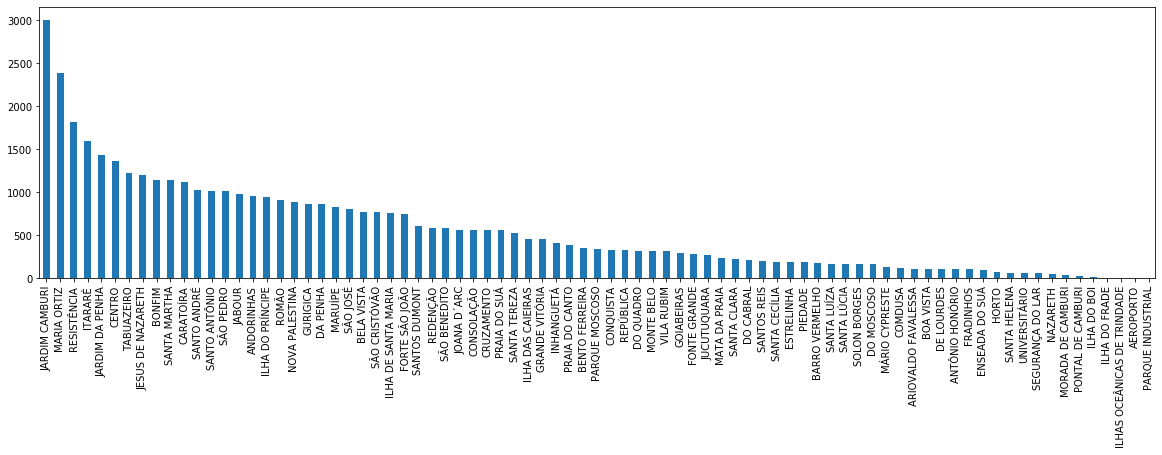

In [7]:
print('There are', len(df['Neighborhood'].unique()), 'different neighborhoods.')
plt.figure(figsize=(20,5))
df['Neighborhood'].value_counts().plot(kind='bar', rot=90)
plt.show()

To use categorical variables in our model, we'll need to 'one-hot encode' them by creating individual binary indicators for each category. We'll create a helper function, `replace_categories_with_one_hot()`, to do this. We also need to look at the time difference between appointment scheduling and the appointment itself. We'll create another helper function, `difference_in_days()`, that will tell us how many days ahead of time the appointment was scheduled.

In [8]:
def replace_categories_with_one_hot(df, col):
    return pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col)], axis=1)

def difference_in_days(df, col1, col2):
    return (df[col2].dt.date - df[col1].dt.date).dt.days

With these helpers defined, we will add several new features. These are described in comments (e.g. `# comment`) in the code block below.

In [9]:
# How many days have elapsed between scheduling the appointment and the appointment itself?
df['WaitLength'] = difference_in_days(df, 'ScheduledDay', 'AppointmentDay')

# Was this a same-day appointment?
df['SameDay'] = (df['WaitLength'] == 0).astype(np.int64)

# In which hour of the day was it scheduled?
df['ScheduledHour'] = df['ScheduledDay'].dt.hour

# On which day of the week was it scheduled? Which day was the appointment?
df['ScheduledDayOfWeek'] = df['ScheduledDay'].dt.dayofweek
df['AppointmentDayOfWeek'] = df['AppointmentDay'].dt.dayofweek

# Now, remove datetime columns
df = df.drop(['ScheduledDay', 'AppointmentDay'], axis=1)

# Convert categorical variables with > 2 categories to one-hot encoding
df = replace_categories_with_one_hot(df, 'Handicap')
df = replace_categories_with_one_hot(df, 'Neighborhood')
df = replace_categories_with_one_hot(df, 'ScheduledHour')
df = replace_categories_with_one_hot(df, 'ScheduledDayOfWeek')
df = replace_categories_with_one_hot(df, 'AppointmentDayOfWeek')

# Convert categorical variables with 2 categories to binary encoding
df['Sex'] = (df['Sex'] == 'F').astype(np.int64)
df['No-show'] = (df['No-show'] == 'Yes').astype(np.int64)

# View resulting dataframe
df.head(10)

,Sex,Age,Scholarship,Hypertension,Diabetes,Alcoholism,SMS_received,No-show,WaitLength,SameDay,...,ScheduledDayOfWeek_2,ScheduledDayOfWeek_3,ScheduledDayOfWeek_4,ScheduledDayOfWeek_5,AppointmentDayOfWeek_0,AppointmentDayOfWeek_1,AppointmentDayOfWeek_2,AppointmentDayOfWeek_3,AppointmentDayOfWeek_4,AppointmentDayOfWeek_5
6,1,23.0,0,0,0,0,0,1,2,0,...,1,0,0,0,0,0,0,0,1,0
7,1,39.0,0,0,0,0,0,1,2,0,...,1,0,0,0,0,0,0,0,1,0
11,0,29.0,0,0,0,0,1,1,3,0,...,0,0,0,0,0,0,0,0,1,0
17,1,40.0,1,0,0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,1,0
20,1,30.0,0,0,0,0,0,1,2,0,...,1,0,0,0,0,0,0,0,1,0
21,1,4.0,0,0,0,0,0,1,2,0,...,1,0,0,0,0,0,0,0,1,0
22,0,13.0,0,0,0,0,1,1,4,0,...,0,0,0,0,0,0,0,0,1,0
31,0,12.0,1,0,0,0,0,1,2,0,...,1,0,0,0,0,0,0,0,1,0
44,1,78.0,0,1,1,0,0,1,1,0,...,0,1,0,0,0,0,0,0,1,0
48,1,58.0,0,0,0,0,1,1,3,0,...,0,0,0,0,0,0,0,0,1,0


Finally, we will normalize our only two numeric variables, Age and WaitLength, by subtracting their mean, then dividing by their standard deviation. Our preprocessing is now complete.

In [10]:
df['Age'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()
df['WaitLength'] = (df['WaitLength'] - df['WaitLength'].mean()) / df['WaitLength'].std()

### Question 1
---
In the dataframe above, the 'Hypertension' column is 0 for some patients and 1 for others. What does a value of 0 indicate? What does a value of 1 indicate? Please respond in 1-2 sentences.

### Partitioning our data into train, validation, and test sets
We will first use the `df.sample()` command to randomize the order of our data. This will ensure that we are assigning data to the train, validation, and test sets at random. Having randomized, we'll assign the first 70% of the data to the training set and the second 15% to the validation set. The final 15% will be set aside as a test set, and should used **only at the very end of the exercise**, once model development is complete. In this code block, we also separate our labels (y), which are found in the 'No-show' column, from our feature variables (x) in the other columns.

In [11]:
shuffled_df = df.sample(frac=1, random_state=0).reset_index(drop=True)

val_start_idx = int(.7 * len(df))
test_start_idx = int(.85 * len(df))

x_train = shuffled_df[:val_start_idx].drop('No-show', axis=1)
x_val = shuffled_df[val_start_idx:test_start_idx].drop('No-show', axis=1)
x_test = shuffled_df[test_start_idx:].drop('No-show', axis=1)

y_train = shuffled_df[:val_start_idx]['No-show']
y_val = shuffled_df[val_start_idx:test_start_idx]['No-show']
y_test = shuffled_df[test_start_idx:]['No-show']

print('Our train, validation, and test sets contain %i, %i, and %i instances, respectively.' % (
    len(x_train), len(x_val), len(x_test)))

Our train, validation, and test sets contain 31246, 6696, and 6696 instances, respectively.


### Fitting a logistic regression model
---
We're now ready to fit a logistic regression model to our data. We will create the model using the `LogisticRegression()` command, then fit it to our training data (i.e. learn which parameter values are best) using the model's `.fit()` method. Once we have a fitted model, we are free to check its performance on the validation set. For now, we'll use accuracy as our performance metric. Accuracy may be calculated as $\frac{\text{number of correct predictions}}{\text{number of predictions in total}}$. We'll explore other performance metrics later in the course.

In [12]:
# Fit the model

lrm = LogisticRegression()
lrm.fit(x_train, y_train)

# Make predictions on our training set
train_predictions = lrm.predict(x_train)
train_accuracy = sum(y_train == train_predictions) / len(train_predictions)

# Make predictions on our validation set
val_predictions = lrm.predict(x_val)
val_accuracy = sum(y_val == val_predictions) / len(val_predictions)
    
print('The logistic regression model is %.2f%% accurate on the training set' % (train_accuracy * 100))
print('The logistic regression model is %.2f%% accurate on the validation set' % (val_accuracy * 100))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The logistic regression model is 67.44% accurate on the training set
The logistic regression model is 67.49% accurate on the validation set


### Fitting a multilayer perceptron model
---
Alternatively, we can fit a multilayer perceptron to our data. Similar to before, we'll create the model using the `MLPClassifier()` command, then fit it to our training data (i.e. learn which parameter values are best) using the model's `.fit()` method. Once we have a fitted model, we are free to check its performance on the validation set, again using accuracy as our performance metric.

The architecture of the MLP model is specified using the `hidden_layer_sizes` parameter. If we want one hidden layer that is 100 values wide, we can say `hidden_layer_sizes=(100)`. If we want three hidden layers, each with 10 values, we can say `hidden_layer_sizes=(10, 10, 10)`. To start, let's start with *no* hidden layers to verify that an MLP with no hidden layers is the same as logistic regression.

In [13]:
# Fit the model
mlp = MLPClassifier(hidden_layer_sizes=(), alpha=1e-3)
mlp.fit(x_train, y_train)

# Make predictions on our training set
train_predictions = mlp.predict(x_train)
train_accuracy = sum(y_train == train_predictions) / len(train_predictions)

# Make predictions on our validation set
val_predictions = mlp.predict(x_val)
val_accuracy = sum(y_val == val_predictions) / len(val_predictions)
    
print('The multilayer perceptron model is %.2f%% accurate on the training set' % (train_accuracy * 100))
print('The multilayer perceptron model is %.2f%% accurate on the validation set' % (val_accuracy * 100))

The multilayer perceptron model is 67.35% accurate on the training set
The multilayer perceptron model is 67.53% accurate on the validation set


Now, let's start exploring MLP architectures. We'll first try a model with one fairly wide hidden layer and set `early_stopping=True` to mitigate possible overfitting and reduce training time.

In [14]:
# Try one wide hidden layer
mlp = MLPClassifier(hidden_layer_sizes=(100), early_stopping=True)
mlp.fit(x_train, y_train)

# Make predictions on our training set
train_predictions = mlp.predict(x_train)
train_accuracy = sum(y_train == train_predictions) / len(train_predictions)

# Make predictions on our validation set
val_predictions = mlp.predict(x_val)
val_accuracy = sum(y_val == val_predictions) / len(val_predictions)
    
print('The multilayer perceptron model is %.2f%% accurate on the training set' % (train_accuracy * 100))
print('The multilayer perceptron model is %.2f%% accurate on the validation set' % (val_accuracy * 100))

The multilayer perceptron model is 70.37% accurate on the training set
The multilayer perceptron model is 67.41% accurate on the validation set


### Question 2
---
How many parameters does the MLP above contain? Note that there are 123 features, and the multilayer perceptron contains a single hidden layer containing 100 units (i.e., latent features).

### Question 3
---
It looks like we weren't able to improve on our logistic regression model using a multilayer perceptron model. Why might this be the case? There isn't a single correct answer here, but your response should include some thoughts on circumstances in which an MLP might be expected to improve performance. Please respond in one brief paragraph.

### Question 4
---
In your opinion, could this model be useful in a clinical setting? Why or why not? Please respond in one brief paragraph.

### Wrapping Up:
---
Write your responses in a separate document. Please submit this file as 'Computational Exercise 1' in Sakai.